In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import time
import pynq
from os import getcwd, path
from pathlib import Path
root = getcwd()
BIT = path.join(root, 'conv_design_0.bit')

# np load error fix
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

from sys import path as sp
sp.append(path.join((Path.cwd()).parent,"scripts"))


# Initialisation

outputs: <br>
0: Grenade
1: Reload
2: Exit
3: Shield
4: IDLE
5: IGNORE

In [2]:
from filepaths import paths
from start_detector import Detector

In [3]:
fpga_detector = Detector()

# Live Testing

In [ ]:
# Constant stream of 6 datapoints
input_stream = []
state_of_game = True # In Gameplay

while (state_of_game):
    predicted_outcome = fpga_detector.eval_data(input_stream)
    print(predicted_outcome)
    # Do whatever with outcome

# Falsify Data (Pre-live implementation of sensor)

In [4]:
from dataloader import get_real_testdata, load_to_df
from modelling_utils import scale_vals

In [5]:
testfiles=get_real_testdata()
train_cols = ['Activity_code', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']
test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
targetfiles = testfiles
cols = test_cols
targetfiles

[PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/idle_shield.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/walk.txt')]

In [29]:
idx = 1
df = load_to_df(targetfiles[idx:idx+1], cols)
df['gz'] = df['gz'].str.slice(start=0, stop=-1)
df['gz'] = df['gz'].astype('int')

df_copy = df.copy()
timestep = 20
data = scale_vals(df_copy)

testing_class = [data.iloc[i].tolist() for i in range(data.shape[0])]

In [30]:
out = []
for d in testing_class:
    o = fpga_detector.eval_data(d)
    out.append(o)

/home/xilinx/jupyter_notebooks/capstoneml/scripts/dataloader.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["a"]=np.linalg.norm((data["ax"],data["ay"],data["az"]), axis=0)
/home/xilinx/jupyter_notebooks/capstoneml/scripts/dataloader.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["g"]=np.linalg.norm((data["gx"],data["gy"],data["gz"]), axis=0)


[array([1.], dtype=float32)]
[array([2.], dtype=float32)]
[array([1.], dtype=float32)]


In [31]:
keep=[]
for i in range(0,len(out)):
    if out[i]!=5:
        keep.append(i)
    
for i in keep:
    print(out[i], end=", ")


4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, [3.], [1.], 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, [1.], [2.], [2.], [1.], 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [32]:
import matplotlib.pyplot as plt
from visualisers import plot_full_v2

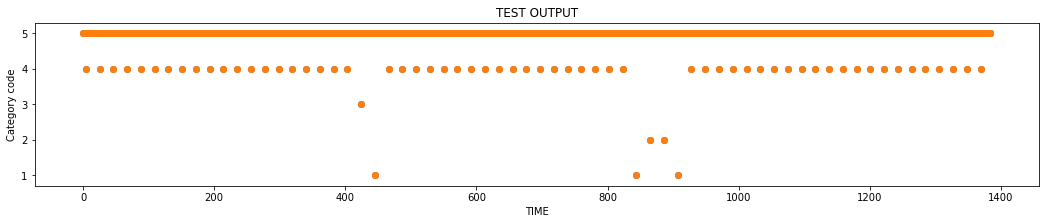

In [33]:
# y_data = [out[i] for i in (keep)]
# x_data = [i for i in range(len(keep))]
y_data = [i for i in (out)]
x_data = [i for i in range(len(out))]
plt.rcParams["figure.figsize"] = (18,3)
plt.scatter(x_data, y_data, label='prediction')
plt.scatter(x_data, y_data, label='prediction')
plt.xlabel('TIME')
plt.ylabel('Category code')
plt.title('TEST OUTPUT')
# plt.legend()
plt.show()

No handles with labels found to put in legend.


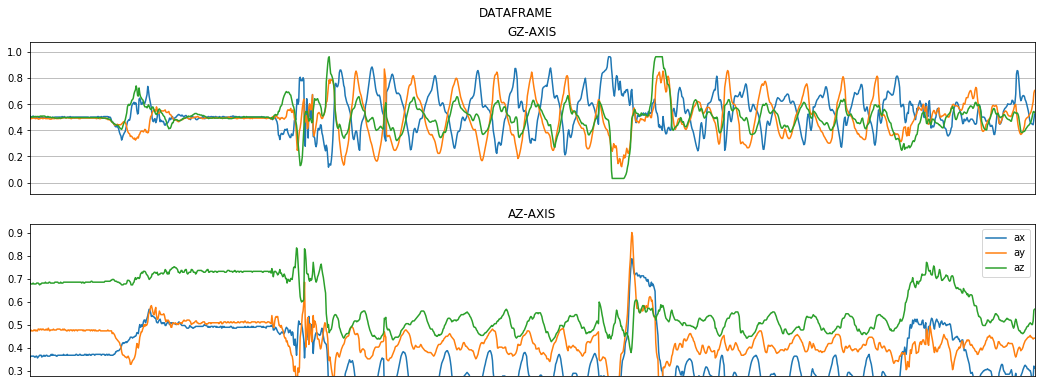

In [34]:
df_copy['time']=[i+1 for i in range(df.shape[0])]
plot_full_v2(df_copy)